In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Removing unsupported file: {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=8)

Found 305 files belonging to 2 classes.


In [6]:
data = data.map(lambda x, y: (x / 255.0, y))

In [7]:
dataset_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.2)

In [8]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [10]:
model = Sequential([
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

C:\Users\jigis\Anaconda3\envs\tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
logdir = 'logs'

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.5968 - loss: 0.7505 - val_accuracy: 0.6429 - val_loss: 0.6162
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.6578 - loss: 0.6232 - val_accuracy: 0.7500 - val_loss: 0.5306
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7973 - loss: 0.5003 - val_accuracy: 0.8929 - val_loss: 0.3650
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.8454 - loss: 0.3983 - val_accuracy: 0.8214 - val_loss: 0.4289
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9204 - loss: 0.2526 - val_accuracy: 0.8571 - val_loss: 0.3235
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9392 - loss: 0.1442 - val_accuracy: 0.9286 - val_loss: 0.3349
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9484 - loss: 0.1934 - val_accuracy: 0.9464 - val_loss: 0.1881
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9734 - loss: 0.1366 - val_accuracy: 0.

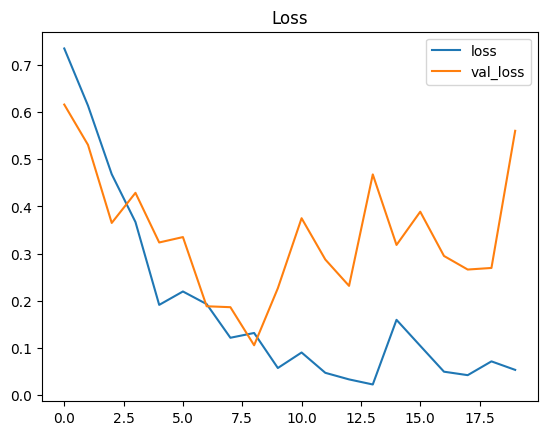

In [15]:
plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()
plt.show()

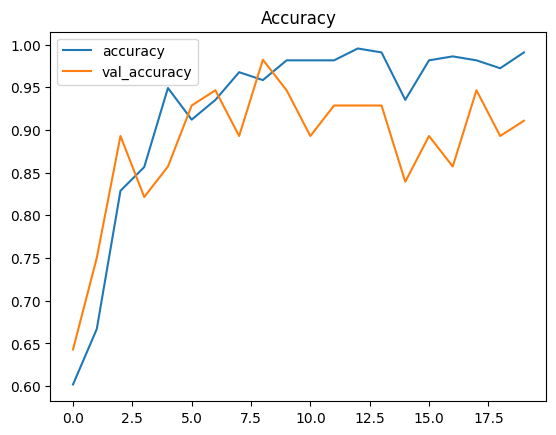

In [16]:
plt.figure()
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

In [17]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [18]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred = tf.round(y_pred)

    if len(y.shape) == 1:
        y = np.expand_dims(y, axis=-1)

    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    pre.update_state(y_tensor, y_pred_tensor)
    re.update_state(y_tensor, y_pred_tensor)
    acc.update_state(y_tensor, y_pred_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


In [19]:
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

Precision: 0.88235295
Recall: 0.8333333
Accuracy: 0.8484849


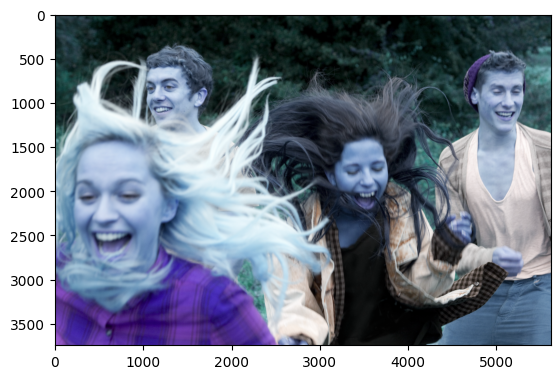

In [20]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

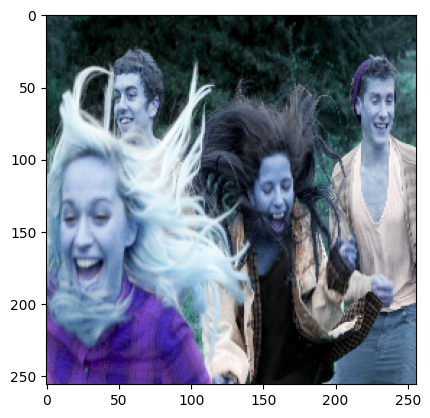

In [21]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [22]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [23]:
yhat

array([[0.00137783]], dtype=float32)

In [24]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [26]:
from tensorflow.keras.models import load_model

In [27]:
model.save(os.path.join('models','imageclassifier.h5'))

In [29]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [30]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


array([[0.00137783]], dtype=float32)